In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import missingno as msno
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import sys
sys.path.append('../lib')
 

from lib import *
from mltools import  mltoos_recommender


In [2]:
#!pip install wordcloud
#!pip install missingno

In [3]:
# load data
book_features = pd.read_csv('../data/books_data.csv', low_memory=False)

ratings = pd.read_csv('../data/Books_rating.csv', low_memory=False)


In [4]:
book_features.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [5]:
ratings.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


## Summary Statistics ##

In [6]:
book_features.describe()


,ratingsCount
count,49752.000000
mean,21.252975
std,201.340431
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4895.000000


In [7]:
ratings.describe()

,Price,review/score,review/time
count,481171.000000,3.000000e+06,3.000000e+06
mean,21.762656,4.215289e+00,1.132307e+09
std,26.206541,1.203054e+00,1.493202e+08
min,1.000000,1.000000e+00,-1.000000e+00
25%,10.780000,4.000000e+00,9.999072e+08
50%,14.930000,5.000000e+00,1.128298e+09
75%,23.950000,5.000000e+00,1.269130e+09
max,995.000000,5.000000e+00,1.362355e+09


## Checking missing values ##

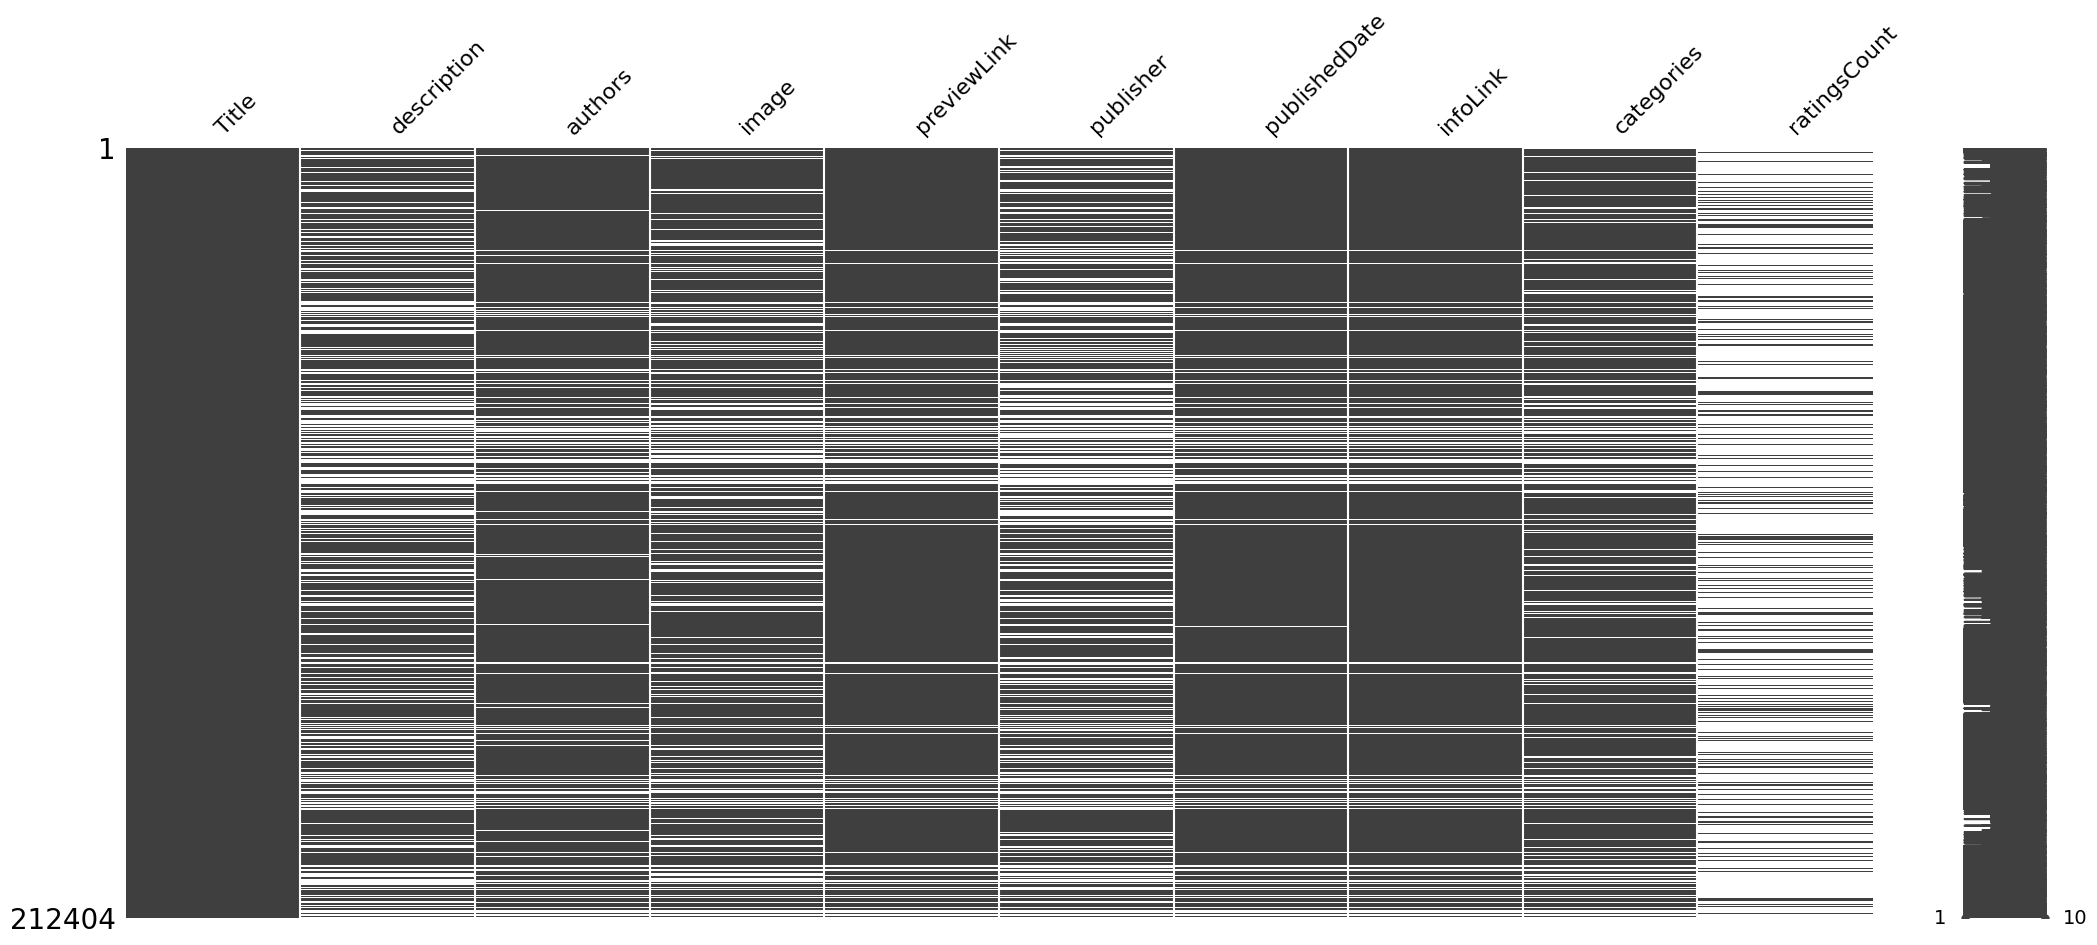

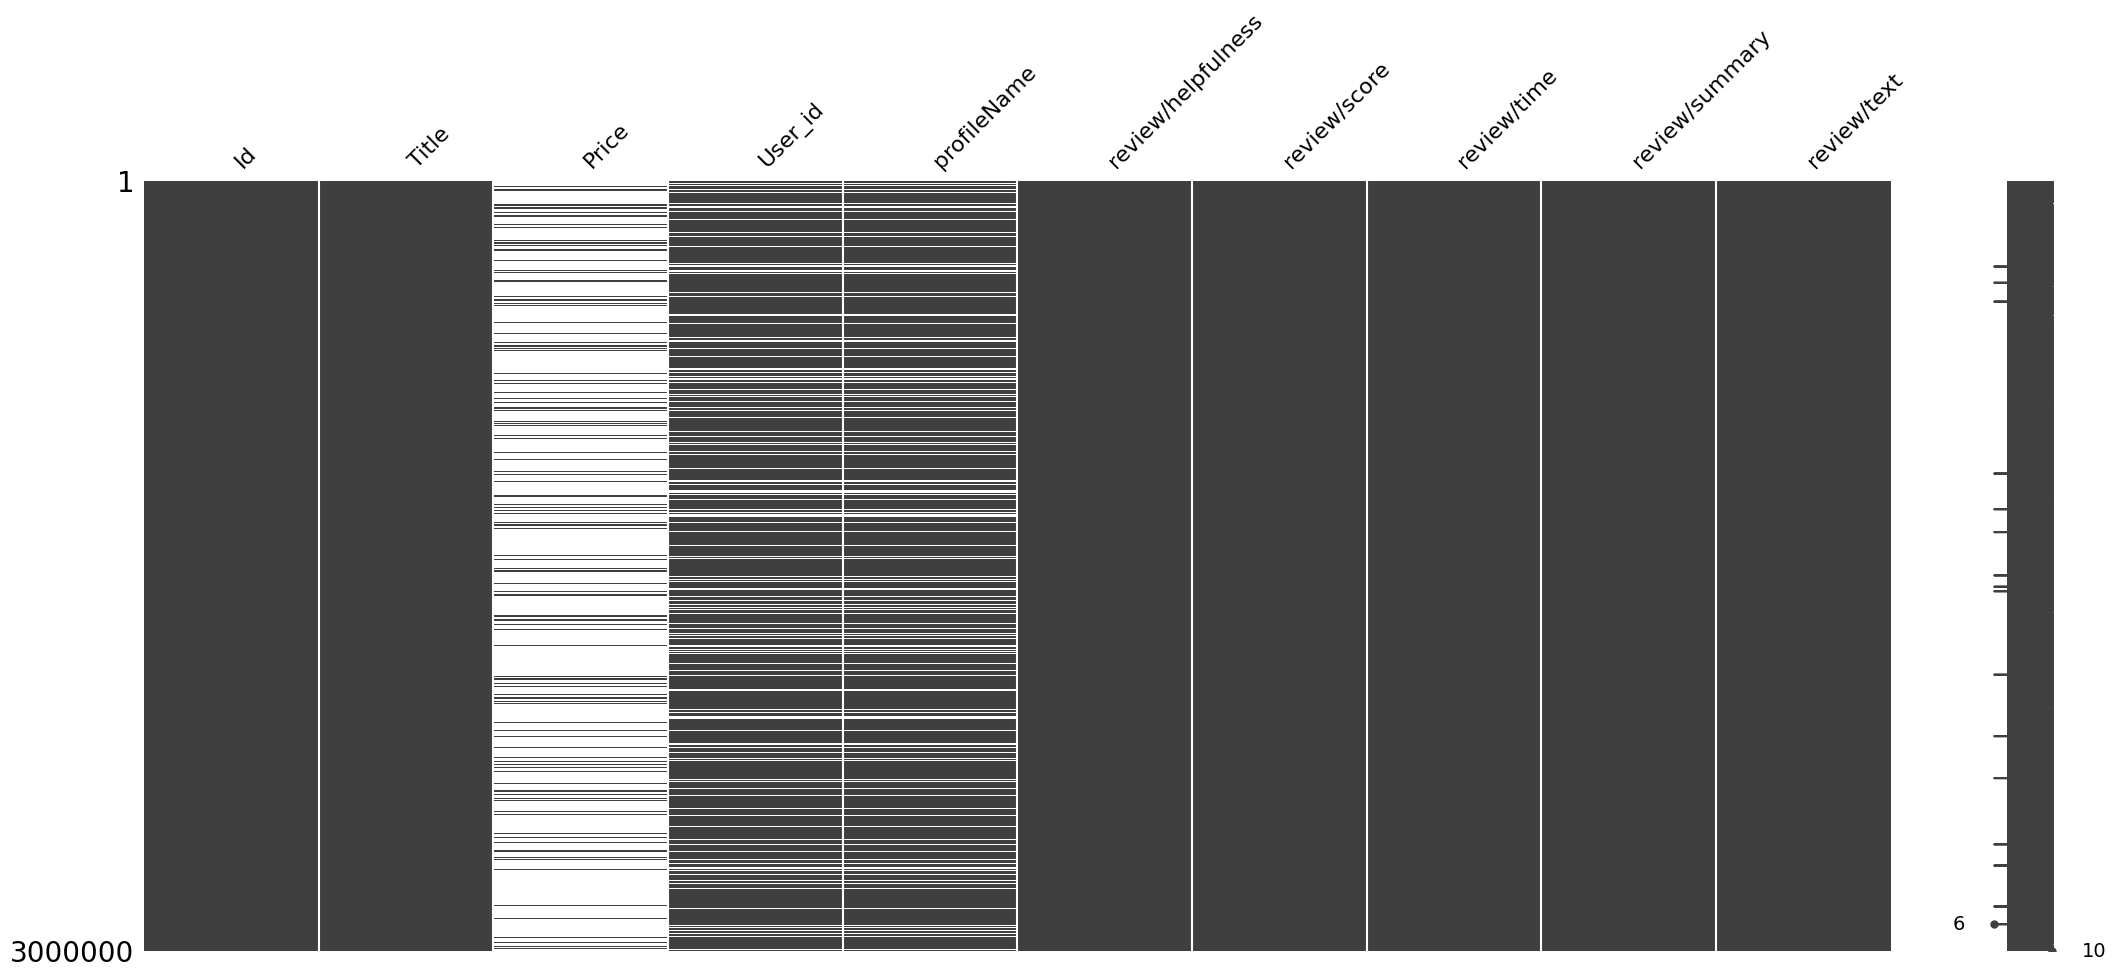

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64
Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64


In [8]:
# Visualize missing values
msno.matrix(book_features)
plt.show()

msno.matrix(ratings)
plt.show()

# Calculate missing values
print(book_features.isnull().sum())
print(ratings.isnull().sum())


## Data Cleaning ##
### Handling missing data and duplicates ###


In [9]:
# Handle missing values in books dataframe
book_features = book_features.dropna(subset=['Title', 'description', 'authors'])

# Handle missing values in ratings dataframe
ratings = ratings.dropna(subset=['Title', 'review/score'])

# Remove duplicates if any
book_features = book_features.drop_duplicates(subset=['Title'])
ratings = ratings.drop_duplicates(subset=['Id'])


### Checking for data types and converting ###

In [10]:
# Check data types
print(book_features.dtypes)
print(ratings.dtypes)

# Convert data types if necessary
book_features['publishedDate'] = pd.to_datetime(book_features['publishedDate'], errors='coerce')
ratings['review/time'] = pd.to_datetime(ratings['review/time'], unit='s')


Title             object
description       object
authors           object
image             object
previewLink       object
publisher         object
publishedDate     object
infoLink          object
categories        object
ratingsCount     float64
dtype: object
Id                     object
Title                  object
Price                 float64
User_id                object
profileName            object
review/helpfulness     object
review/score          float64
review/time             int64
review/summary         object
review/text            object
dtype: object


### Exploratory Data Analysis ###

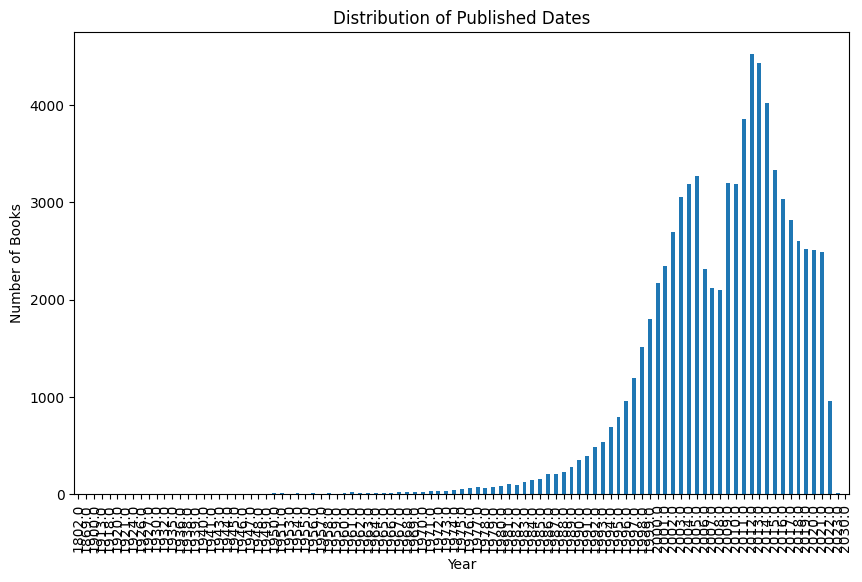

In [11]:
# Distribution of published dates
plt.figure(figsize=(10,6))
book_features['publishedDate'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Published Dates')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.show()


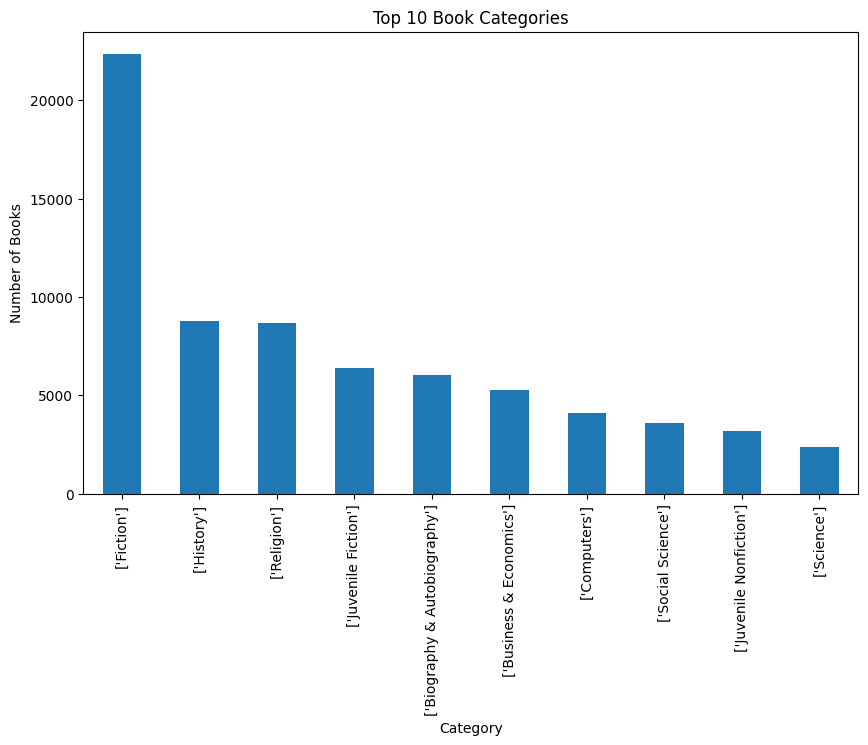

In [12]:
# Top categories
top_categories = book_features['categories'].value_counts().head(10)
plt.figure(figsize=(10,6))
top_categories.plot(kind='bar')
plt.title('Top 10 Book Categories')
plt.xlabel('Category')
plt.ylabel('Number of Books')
plt.show()


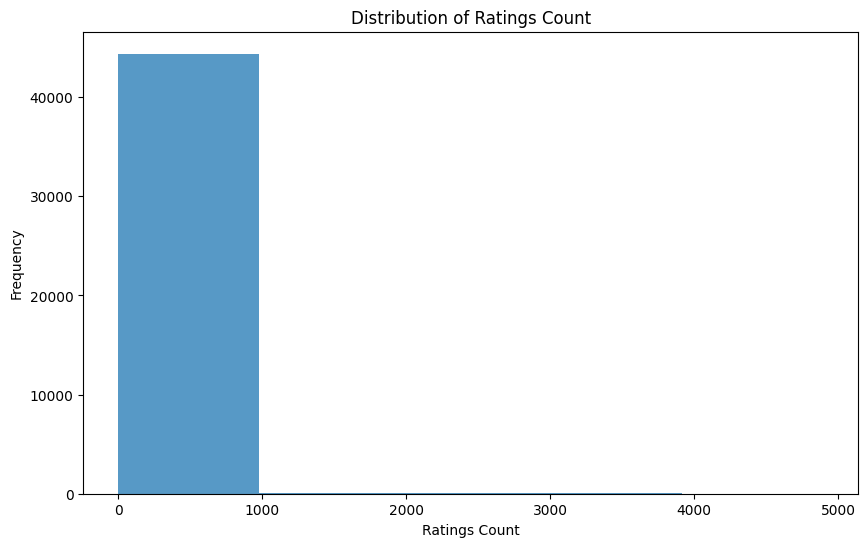

In [13]:
# Rating count distribution
plt.figure(figsize=(10, 6))
plt.hist(book_features['ratingsCount'].dropna(), bins=5, alpha=0.75)
plt.title('Distribution of Ratings Count')
plt.xlabel('Ratings Count')
plt.ylabel('Frequency')
plt.show()


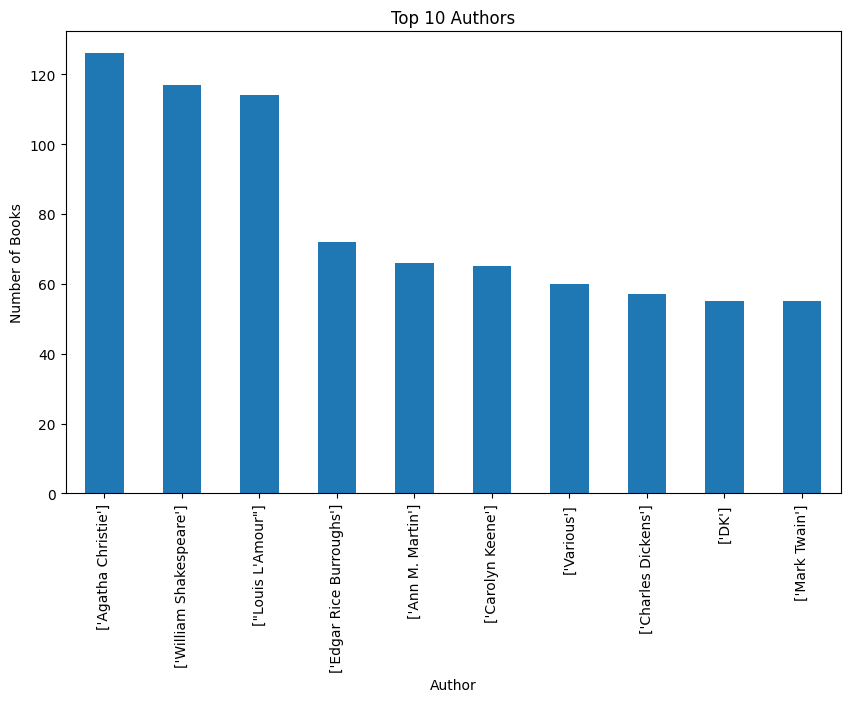

In [14]:
# Authors Analysis
top_authors = book_features['authors'].value_counts().head(10)
plt.figure(figsize=(10,6))
top_authors.plot(kind='bar')
plt.title('Top 10 Authors')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.show()


In [15]:
"""# Word count of description
text = ' '.join(book_features['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Book Descriptions')
plt.show()"""


"# Word count of description\ntext = ' '.join(book_features['description'].dropna())\nwordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)\nplt.figure(figsize=(10,6))\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud of Book Descriptions')\nplt.show()"

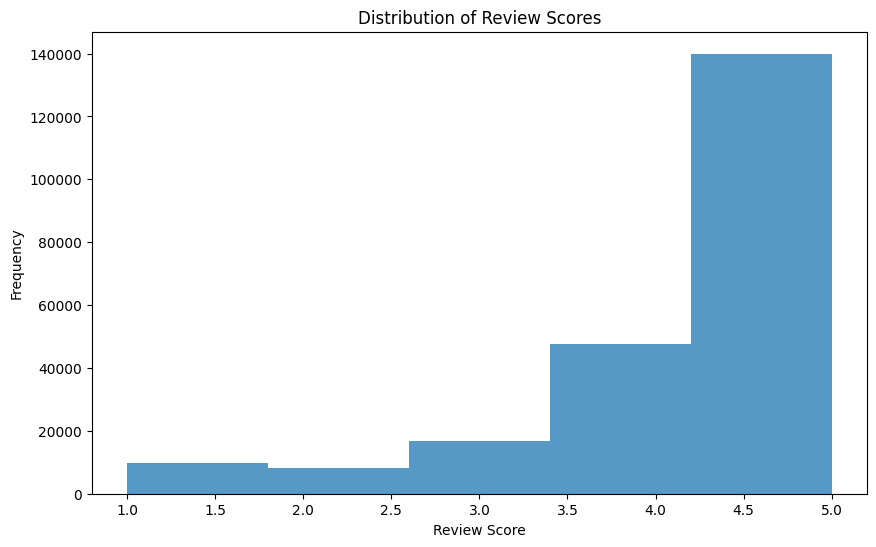

In [16]:
# Distribution of review scores
plt.figure(figsize=(10,6))
plt.hist(ratings['review/score'].dropna(), bins=5, alpha=0.75)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()



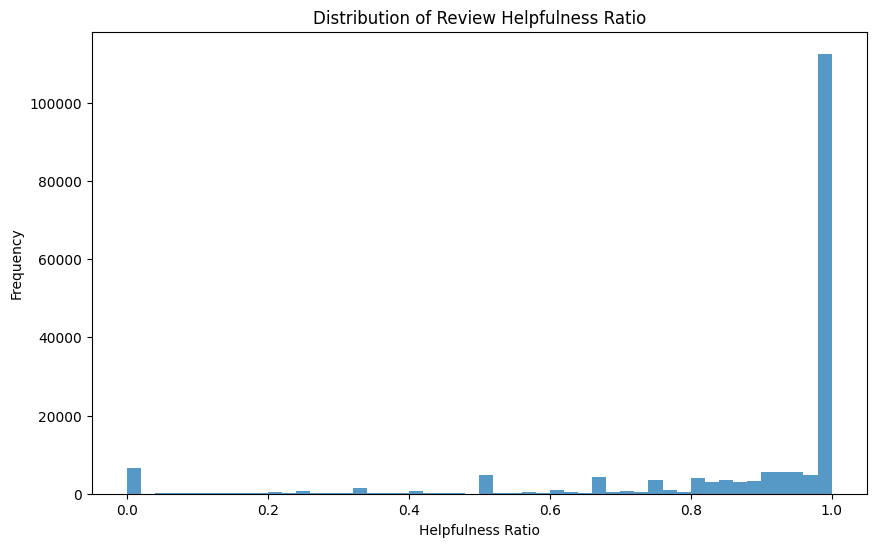

In [17]:
# Distribution of review/helpfulness
ratings['helpfulness_numerator'] = ratings['review/helpfulness'].apply(lambda x: int(x.split('/')[0]))
ratings['helpfulness_denominator'] = ratings['review/helpfulness'].apply(lambda x: int(x.split('/')[1]))
ratings['helpfulness_ratio'] = ratings['helpfulness_numerator'] / ratings['helpfulness_denominator']

plt.figure(figsize=(10,6))
plt.hist(ratings['helpfulness_ratio'].dropna(), bins=50, alpha=0.75)
plt.title('Distribution of Review Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')
plt.show()



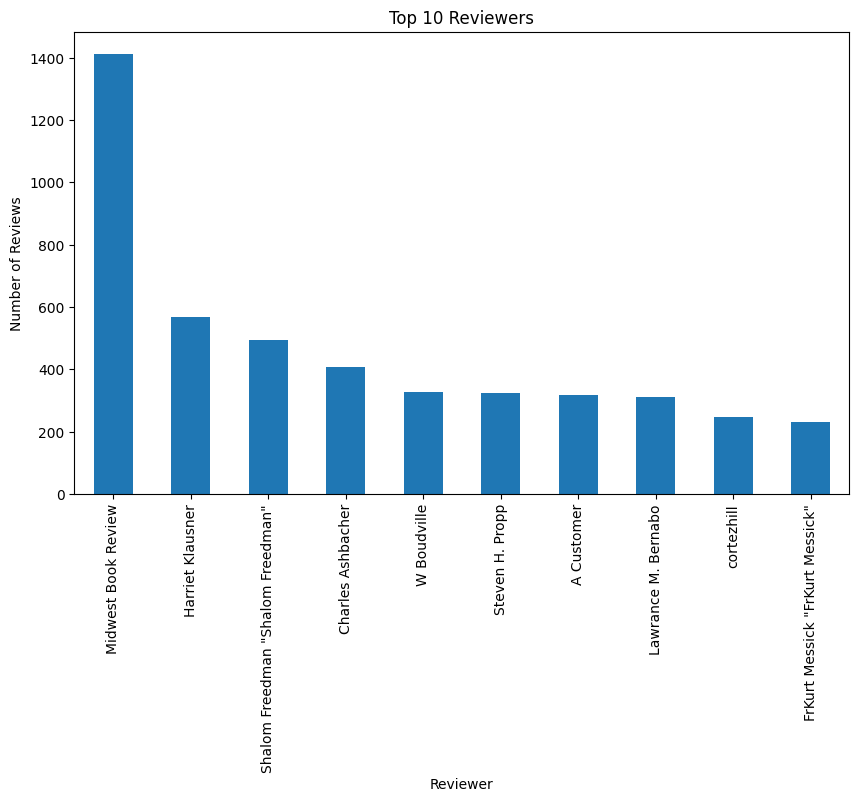

In [18]:
# Top reviewers:
top_reviewers = ratings['profileName'].value_counts().head(10)
plt.figure(figsize=(10,6))
top_reviewers.plot(kind='bar')
plt.title('Top 10 Reviewers')
plt.xlabel('Reviewer')
plt.ylabel('Number of Reviews')
plt.show()


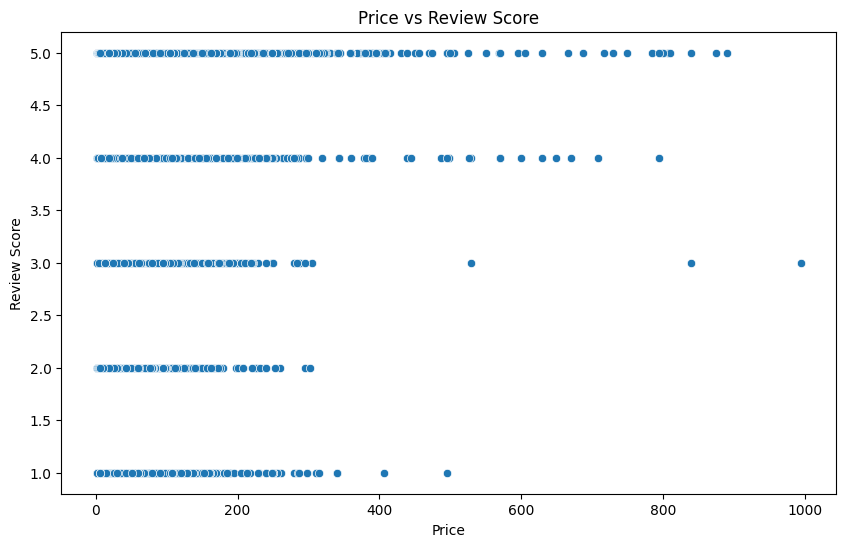

In [19]:
# Checking for correlation between price and review score:
plt.figure(figsize=(10,6))
sns.scatterplot(data=ratings, x='Price', y='review/score')
plt.title('Price vs Review Score')
plt.xlabel('Price')
plt.ylabel('Review Score')
plt.show()


## Features Engineering 
### Calculating Rating Count and Average Rating ###


In [20]:
# Calculate the rating count for each book
rating_counts = ratings.groupby('Title').size().reset_index(name='rating_count')

# Calculate the average rating for each book
average_ratings = ratings.groupby('Title')['review/score'].mean().reset_index(name='average_rating')

# Merge these features into the books dataframe
book_features = book_features.merge(rating_counts, on='Title', how='left')
book_features = book_features.merge(average_ratings, on='Title', how='left')

# Fill NaN values with 0 for rating_count and with the average rating for average_rating
book_features['ratingsCount'] = book_features['ratingsCount'].fillna(0)
book_features['average_rating'] = book_features['average_rating'].fillna(book_features['average_rating'].mean())


In [21]:
book_features[['Title', 'rating_count', 'average_rating']].head()


,Title,rating_count,average_rating
0,Dr. Seuss: American Icon,1,5.0
1,Wonderful Worship in Smaller Churches,1,5.0
2,Whispers of the Wicked Saints,1,1.0
3,The Church of Christ: A Biblical Ecclesiology ...,1,5.0
4,Saint Hyacinth of Poland,1,5.0


### Summary statistics for the new features ###

In [22]:
book_features[['rating_count', 'average_rating']].describe()


,rating_count,average_rating
count,141755.000000,141755.000000
mean,1.049423,4.348300
std,0.286355,1.056146
min,1.000000,1.000000
25%,1.000000,4.000000
50%,1.000000,5.000000
75%,1.000000,5.000000
max,14.000000,5.000000


### Checking the distribution of the new features ###

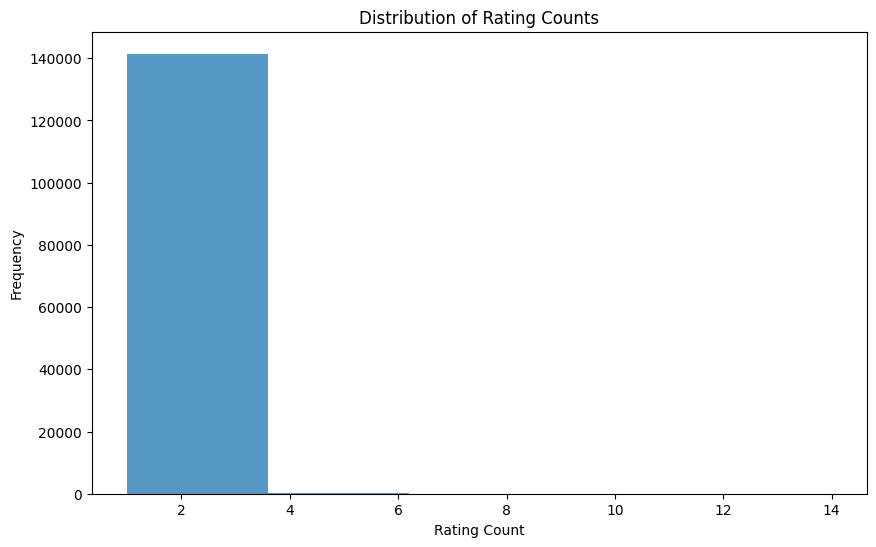

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(book_features['rating_count'].dropna(), bins=5, alpha=0.75)
plt.title('Distribution of Rating Counts')
plt.xlabel('Rating Count')
plt.ylabel('Frequency')
plt.show()


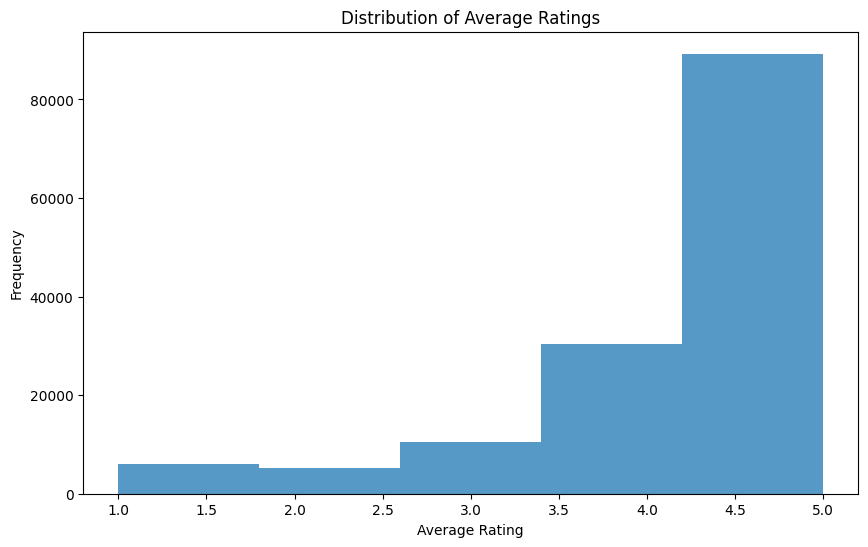

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(book_features['average_rating'].dropna(), bins=5, alpha=0.75)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


In [25]:
# Combine relevant text features for vectorization
book_features['description'] = book_features['description'].fillna('')
book_features['Title'] = book_features['Title'].fillna('')
book_features['authors'] = book_features['authors'].fillna('')
book_features['combined_text'] = book_features['Title'] + ' ' + book_features['description'] + ' ' + book_features['authors']

# Verify the combined text column
print(book_features[['Title', 'combined_text']].head())


                                               Title   
0                           Dr. Seuss: American Icon  \
1              Wonderful Worship in Smaller Churches   
2                      Whispers of the Wicked Saints   
3  The Church of Christ: A Biblical Ecclesiology ...   
4                           Saint Hyacinth of Poland   

                                       combined_text  
0  Dr. Seuss: American Icon Philip Nel takes a fa...  
1  Wonderful Worship in Smaller Churches This res...  
2  Whispers of the Wicked Saints Julia Thomas fin...  
3  The Church of Christ: A Biblical Ecclesiology ...  
4  Saint Hyacinth of Poland The story for childre...  


In [26]:

# Vectorize the combined text
book_features['combined_text']=book_features['combined_text'].str.strip().str.lower()

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(book_features['combined_text'])

print(tfidf_matrix.shape)  # (number of books, number of features)

(141755, 5000)


In [27]:
recommender=mltoos_recommender(book_features['combined_text'])

In [48]:
arrays=recommender.get_similarities("queen king prince")

In [49]:
book_features.loc[arrays,['Title','combined_text']]

,Title,combined_text
133305,King's Quest 1: The Floating Castle,king's quest 1: the floating castle the peacef...
59174,The Tale of the Incomparable Prince (Library o...,the tale of the incomparable prince (library o...
57291,"Franny, the Queen of Provincetown (Little Sist...","franny, the queen of provincetown (little sist..."
118584,Ghost King (Stones of Power),ghost king (stones of power) “david gemmell te...
113732,King Arthur : His Knights and Their Ladies,king arthur : his knights and their ladies the...
...,...,...
136816,No One Noticed the Cat,no one noticed the cat after the death of wise...
127920,ROYAL MISTRESSES PB,royal mistresses pb the current prince of wale...
114202,TILABEL,"tilabel inept tilabel, forced to spin, weave, ..."
117460,This thing called life,this thing called life a warm and surprisingly...
